### CIR Model to simulate changes in Interest Rates and Liabilities Hedging

The Cox, Ingersoll & Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rates:
$$dr_t = a(b-r_t)dt + \sigma\sqrt{r_t}dW_t$$

In [1]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from risk_kit import Metrics, pre_processing_ind, get_ind30_nfirms, get_ind30_size, plot_ef2
import ipywidgets as widgets
from IPython.display import display

pd.options.display.float_format = '{:.6f}'.format

In [2]:
m = Metrics()

Interest rates change over time and they have an enormous impact on the funding ratio. Therefore it is essential to model them in order to understand how our portfolio evolves over time.

In [3]:
# short rate vs annualized
yearly_int_rate =1
debt= 1 + 1*1
debt

2

In [4]:
# twice per year
1 + 1*0.5 + (1 + 1*0.5)*0.5

2.25

In [5]:
# four times per year
1 +  1*0.25 + (1 +  1*0.25)*0.25 + (1 +  1*0.25 + (1 +  1*0.25)*0.25)*0.25 +\
(1 +  1*0.25 + (1 +  1*0.25)*0.25 + (1 +  1*0.25 + (1 +  1*0.25)*0.25)*0.25)*0.25

2.44140625

In general if we compound every 1/N per year (i.e. N times a year),
with r being the yearly interest rate we get:

$$\left(1+\frac{r}{N}\right)^N$$


In [6]:
(1+1/2)**2

2.25

In [7]:
(1+1/100)**100

2.7048138294215285

In [8]:
# e number (for N very large)
(1+1/10000)**10000

2.7181459268249255

Annual Rate vs Instantaneous (or Short) Rate relationship:

$$ r_{inst} = ln(1+r_{annual}) $$

In [9]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    m.cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[0].plot(legend=False)

In [10]:
# show interest rates from CIR model
controls = widgets.interactive(show_cir,
                               r_0 = (0, .15, .01),
                               a = (0, 1,.1),
                               b = (0, .15, .01),
                               sigma = (0, .1, .01),
                               n_scenarios = (1, 100)
)
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

OBJECTIVE: Let's figure out what happens to the price of the Zero Coupon Bond (we were using as a hedge) when Interest Rates change

The CIR model can also be used to generate the movement of of bond prices for a zero coupon that are implied by the generated interest rate, using the following equation:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$

In [11]:
# show Zero Coupon Bond (ZCB) price over time from CIR model
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    m.cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False)

In [12]:
controls = widgets.interactive(show_cir_prices,
                               r_0 = (0, .15, .01),
                               a = (0, 1,.1),
                               b = (0, .15, .01),
                               sigma = (0, .1, .01),
                               n_scenarios = (1, 100)
)
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

COMMENT: this is the evolution in Price of a Zero Coupon Bond (ZCB). As interests go up the price of ZCB goes down.
As interesta rates go down the price of Bond goes up. The price of the Bond no matter what parameter you change will eventually converge to 1 at maturity date.
Along the way there could be a lot of variation

We built a model that change interest rates and how a ZCB price change. Now we are able to compare an hedge done with
a ZCB w.r.t. using cash as hedge.

In [13]:
# let's assume that we have some assets (or cash on hand)
a_0=0.75
# let's simulate the next 10 years for the interest rates and ZC Bond
rates, bond_prices = m.cir(n_years=10, r_0=0.03, b= 0.03, n_scenarios=10)
# let's assume for simplicity that we are going to model my liabilities as a ZC Bond
# my liabilities that I am trying to match is 1 Mill.$ at the end of 10 years,
# since interest rate change, my liabilities are changing over time
liabilities = bond_prices
# let's figure out the what the price of a ZC Bond today is
zc_10 = pd.Series(data=[1], index=[10])
zc_0= m.pv(zc_10, r=0.03)
# Scenario1: buy ZC Bonds with my assets
n_bonds = a_0/zc_0
# we know how my assets are changing over time
av_zc_bonds = n_bonds*bond_prices
# Scenario2: assets value in cash changing over time due to interest rates
av_cash = a_0*(rates/12 + 1).cumprod()

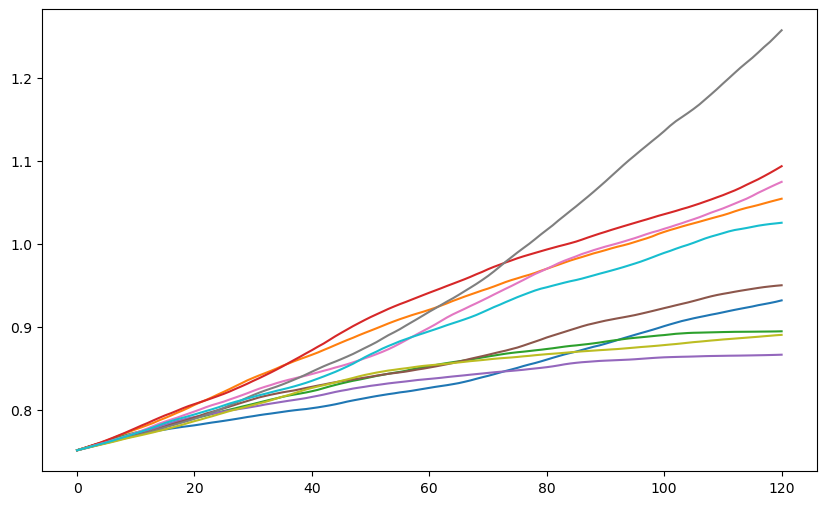

In [14]:
av_cash.plot(legend=False);

COMMENT: as interest change, we can see that some of the scenarios don't cover
my requirements of 1 Mill. in 10 years  (<1). If you are a pension fund this cannot be acceptable. The same is valid for a private investor. 

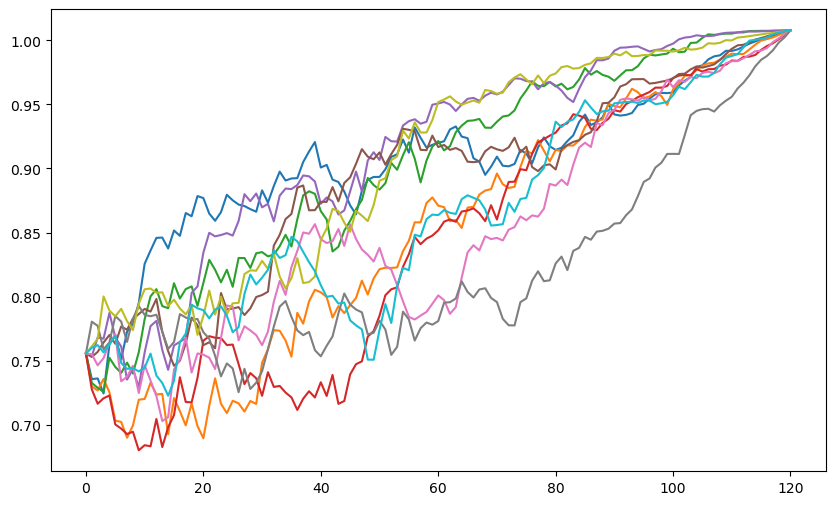

In [15]:
av_zc_bonds.plot(legend=False);

COMMENT: with a ZC Bond we reach our objective at the end of 10 years. 

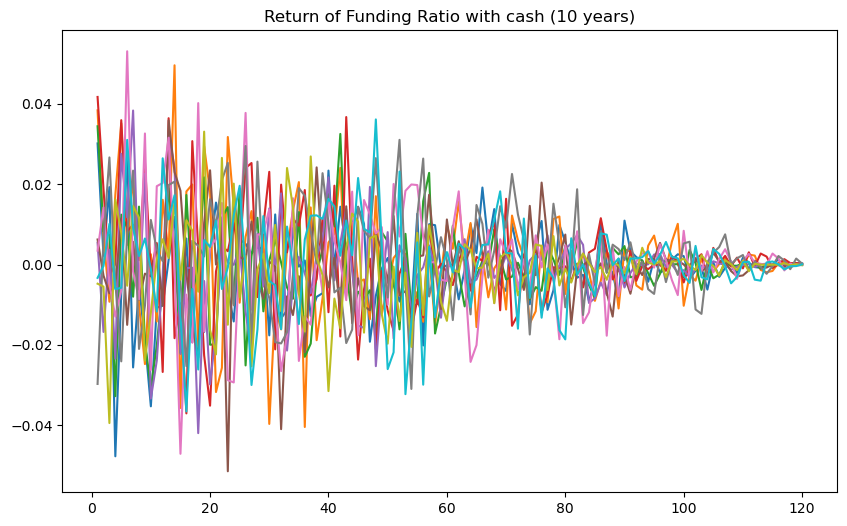

In [16]:
# Let's look at the funding ratio with cash over time
(av_cash/liabilities).pct_change().plot(title= "Return of Funding Ratio with cash (10 years)",
                                       legend=False);

COMMENT: change in the funding ratio using cash is pretty wild at the beginning and then stabilizes. So from this perspective cash is very volatile.

In [17]:
# Let's look at the funding ratio with ZC Bonds over time

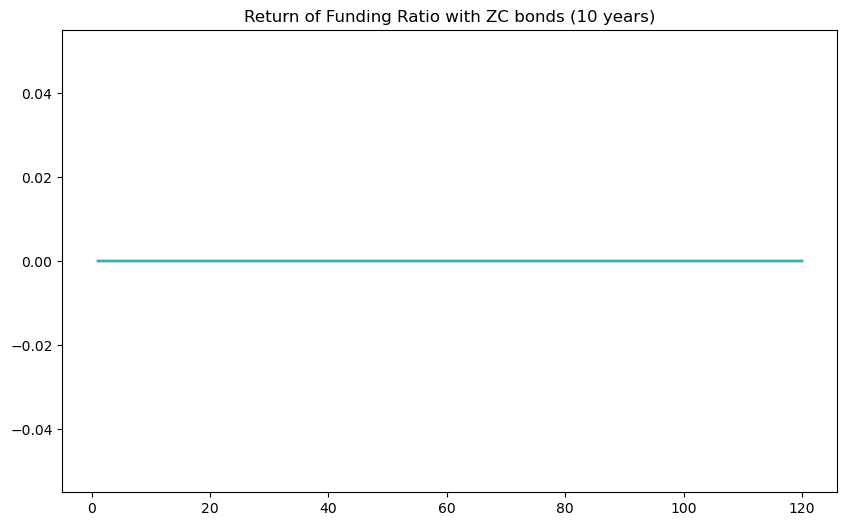

In [18]:
# Let's look at the funding ratio with cash over time
(av_zc_bonds/liabilities).pct_change().plot(title= "Return of Funding Ratio with ZC bonds (10 years)",
                                       legend=False);

COMMENT: change in the funding ratio using ZC Bonds is steady over time.
ZC Bonds are not easily accessible from Private Investors. Even for the Institutiona Investors would be very difficult to find the right exact liabilities match set of Bonds.

In [19]:
a_0=0.75
rates, bond_prices = m.cir(n_years=10, r_0=0.03, b= 0.03, n_scenarios=10000)
liabilities = bond_prices
zc_10 = pd.Series(data=[1], index=[10])
zc_0= m.pv(zc_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12 + 1).cumprod()

In [20]:
# let's look at the Terminal Funding Ratio
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]

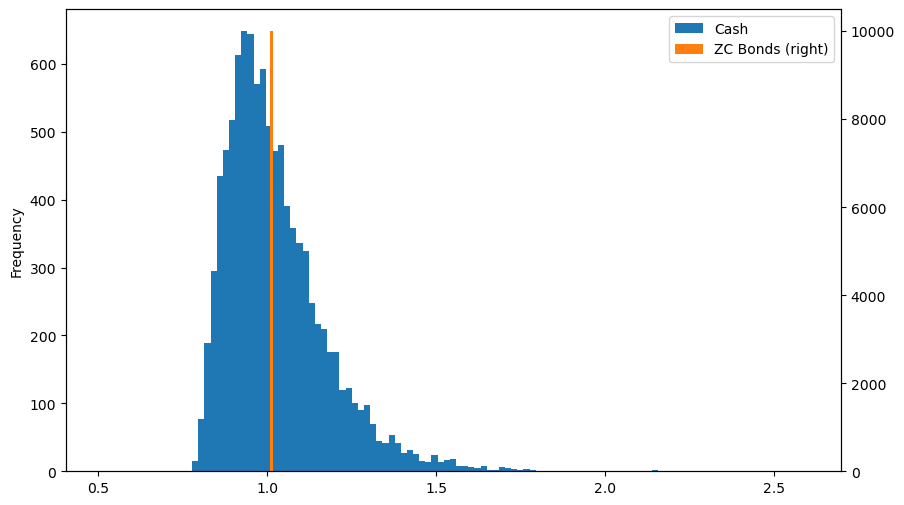

In [21]:
ax = tfr_cash.plot.hist(label="Cash", bins=100, legend=True);
tfr_zc_bonds.plot.hist(ax=ax, label="ZC Bonds", bins=100, legend=True, secondary_y=True);

COMMENT: if you put your money in cash, there are some case in which you would end up not reaching your target of 1 Mill. at the end of 10 years. The objective is fully reached by putting your assets in ZC Bond.For a Private it means that you have the money you need at the time you need them.
For a Pension Fund it maans you keep your promise.

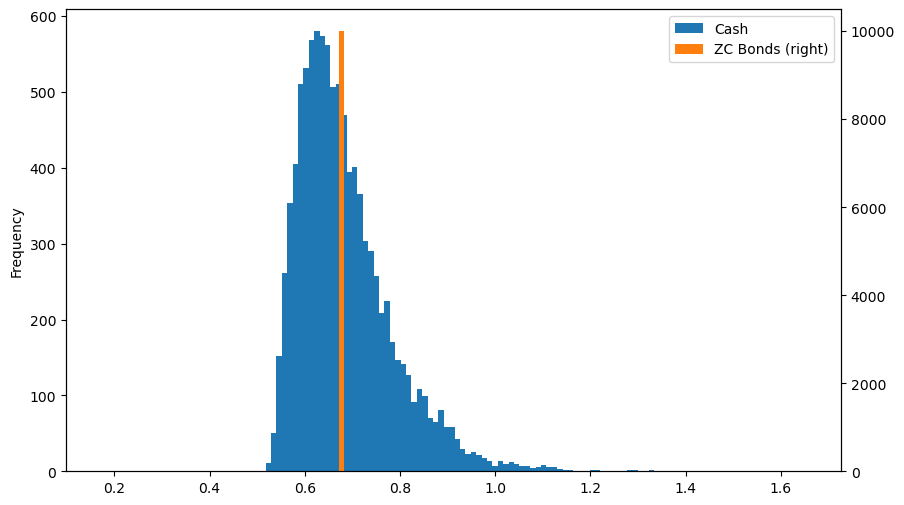

In [22]:
# case with 0.5 in assets
a_0=0.5
rates, bond_prices = m.cir(n_years=10, r_0=0.03, b= 0.03, n_scenarios=10000)
liabilities = bond_prices
zc_10 = pd.Series(data=[1], index=[10])
zc_0= m.pv(zc_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12 + 1).cumprod()
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", bins=100, legend=True);
tfr_zc_bonds.plot.hist(ax=ax, label="ZC Bonds", bins=100, legend=True, secondary_y=True);

COMMENT:In this case it says: you don't have enough cash to reach your objective

COMMENT: Since ZC Bonds are not practical our objective is to have a higher degree of certainty
and we would like to have the spread of the distribution as narrow as possible and the Funding Ratio close to 1 as much as possible.